Initial graph setup:
Graph has 20 nodes and 21 edges


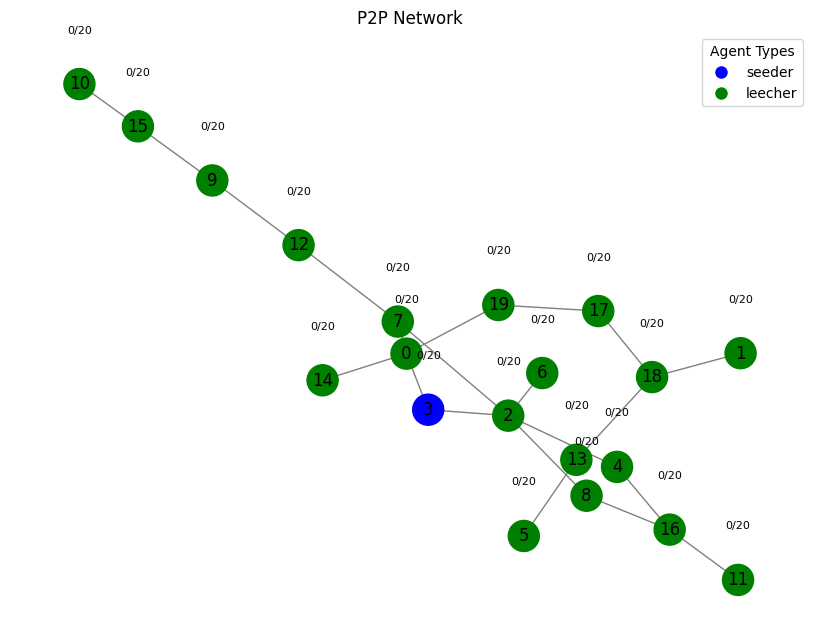

In [1]:
import sys, os, pathlib
project_root = pathlib.Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.graph import erdos_renyi_graph
import src.agent as agent_module
from utils.plotter import draw_graph
from utils.simulator import simulate_round, get_network_stats

# Create and setup the graph
G = erdos_renyi_graph(n=20, p=0.1)
agent_module.assign_n_seeders(G, n=1, seed=42)
FILE_PIECES = 20
print("Initial graph setup:")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
draw_graph(G, FILE_PIECES)


In [2]:
# Init
agent_module.initialize_file_sharing(G, FILE_PIECES, seed=42)

print(str(FILE_PIECES) + " pieces")
for node in G.nodes():
    info = agent_module.get_agent_info(G, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/ {FILE_PIECES} pieces - Complete: {info['is_complete']}")

print(f"\nTotal pieces in network at the moment: {sum(len(G.nodes[node].get('file_pieces', set())) for node in G.nodes())}")


20 pieces
Node 0: leecher - 0/ 20 pieces - Complete: False
Node 1: leecher - 0/ 20 pieces - Complete: False
Node 2: leecher - 0/ 20 pieces - Complete: False
Node 3: seeder - 20/ 20 pieces - Complete: True
Node 4: leecher - 0/ 20 pieces - Complete: False
Node 5: leecher - 0/ 20 pieces - Complete: False
Node 6: leecher - 0/ 20 pieces - Complete: False
Node 7: leecher - 0/ 20 pieces - Complete: False
Node 8: leecher - 0/ 20 pieces - Complete: False
Node 9: leecher - 0/ 20 pieces - Complete: False
Node 10: leecher - 0/ 20 pieces - Complete: False
Node 11: leecher - 0/ 20 pieces - Complete: False
Node 12: leecher - 0/ 20 pieces - Complete: False
Node 13: leecher - 0/ 20 pieces - Complete: False
Node 14: leecher - 0/ 20 pieces - Complete: False
Node 15: leecher - 0/ 20 pieces - Complete: False
Node 16: leecher - 0/ 20 pieces - Complete: False
Node 17: leecher - 0/ 20 pieces - Complete: False
Node 18: leecher - 0/ 20 pieces - Complete: False
Node 19: leecher - 0/ 20 pieces - Complete: False



Initial: 19 leechers incomplete, 0.0% completion rate

 Round 1
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 3 to >> 2

 Round 2
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 3: 3 to >> 0

 Round 3
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 3 to >> 2

 Round 4
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 9: 3 to >> 0

 Round 5
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 5: 3 to >> 0

 Round 6
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 15: 3 to >> 2

 Round 7
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 19: 3 to >> 0

 Round 8
Transfers: 1
Progress: 19 leechers incomplete, 0.0% completion rate
transfers:
  Piece 13: 3 to >> 0

 Round 9
Transfers: 1
Progress: 19 leechers incomplete, 0.0% 

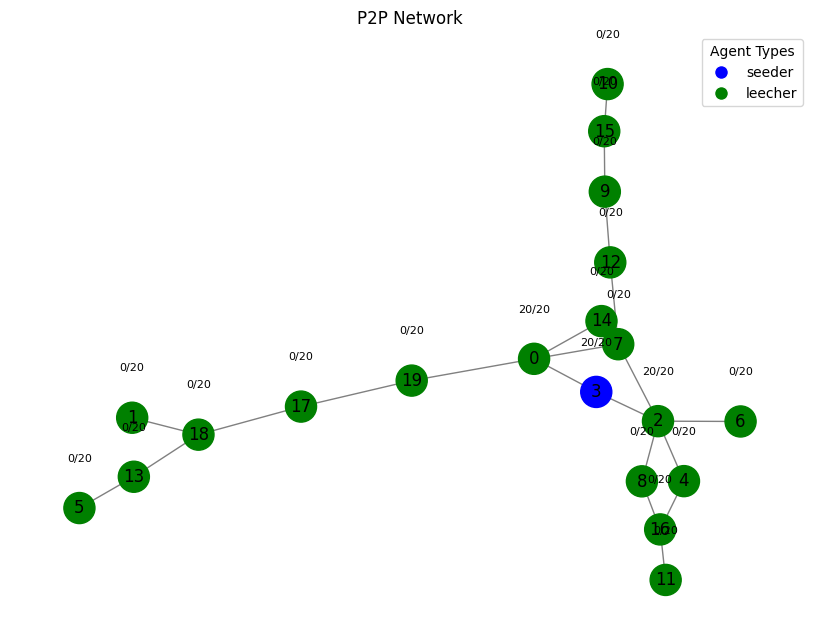

In [3]:
stats = get_network_stats(G, FILE_PIECES)
print(f"Initial: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")

# Run one round of simulation
for round_num in range(1, 80):
    print(f"\n Round {round_num}")
    result = simulate_round(G, FILE_PIECES, seed=42+round_num)
    
    print(f"Transfers: {result['total_transfers']}")
    if result['new_completions']:
        print(f"New completions: {result['new_completions']}")
    
    stats = get_network_stats(G, FILE_PIECES)
    print(f"Progress: {stats['incomplete_leechers']} leechers incomplete, {stats['completion_rate']:.1%} completion rate")
    
    # Show some transfer details
    if result['transfers']:
        print("transfers:")
        for transfer in result['transfers']:  # Show first handful
            print(f"  Piece {transfer['piece']}: {transfer['from']} to >> {transfer['to']}")

print(f"\nFinal network state:")
for node in G.nodes():
    info = agent_module.get_agent_info(G, node)
    print(f"Node {node}: {info['role']} - {info['num_pieces']}/20 pieces - Complete: {info['is_complete']}")

final_stats = get_network_stats(G, FILE_PIECES)

print(f"\nFinal network statistics:")
print(f"Total nodes: {final_stats['total_nodes']}")
print(f"Total edges: {final_stats['total_edges']}")
print(f"Seeders: {final_stats['seeders']}")
print(f"Leechers: {final_stats['leechers']}")
print(f"Complete leechers: {final_stats['complete_leechers']}")
print(f"Incomplete leechers: {final_stats['incomplete_leechers']}")
print(f"Completion rate: {final_stats['completion_rate']:.1%}")
print(f"Total pieces in network: {final_stats['total_pieces_in_network']}")

# Draw the final graph
print(f"\nFinal graph visualization:")
draw_graph(G, FILE_PIECES)